# Constants

In [1]:
#keyword to be searched
KEYWORD = 'surfing'

# max comments to be scraped
MAX = 100

# import the required stuff

In [2]:
import os
import numpy as np
import pandas as pd
import googleapiclient.discovery # youtube api
import re
from tqdm import tqdm # to get cool progress bar
import nltk
# VADER
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy


/Users/vicyria/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# !python -m spacy download en_core_web_sm
# nltk.download('vader_lexicon')

In [4]:
# # for google colab
# def get_youtube_object():
#     # file = open("API_KEY",'r')                  #opening the file containg my API key

#     os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

#     api_service_name = "youtube"
#     api_version = "v3"
#     # DEVELOPER_KEY = file.read()                  #reading the API key from the file, did this for security purpose

#     youtube = googleapiclient.discovery.build(
#         api_service_name, api_version, developerKey = "")
#     return youtube
# youtube = get_youtube_object()

In [5]:
def get_youtube_object():
    file = open("/Users/vicyria/Downloads/API_KEY.txt",'r')                  #opening the file containg my API key

    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = file.read()                  #reading the API key from the file, did this for security purpose

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)
    return youtube
youtube = get_youtube_object()

## preprocessing fucntions to create tokens

In [6]:
# a function to chekc if the token we are trying to make is actually a meaningful token
def is_token_allowed(token):
    return bool(token and str(token).strip() and not token.is_stop and not token.is_punct)



# function to preprocess each token at once
# lemmatization -- get the base word out of the token, e.g. "be" is lemma of "was"
# strip of extra space or punctuation
# convert all to lowercase
def preprocess_token(token):
    return token.lemma_.strip().lower()


# final function which will return a string of created tokens
def create_tokens(string):

    # load the english language
    nlp = spacy.load("en_core_web_sm")

    # create an object of spacy library
    nlp_text = nlp(string)
    complete_filtered_tokens = [preprocess_token(token) for token in nlp_text if is_token_allowed(token)]

    # remove if it is of length 1, i.e. emoticons and other symbols etc.
    complete_filtered_tokens = [x for x in complete_filtered_tokens if len(x)>1]

    # return the tokens as one complete string
    complete_filtered_tokens = " ".join(complete_filtered_tokens)
    return complete_filtered_tokens



## class video

In [7]:
class Video: # video class containing all the data associated with each video id containing comments, metaData, channelData
    def __init__(self):
        self.comments = 0
        self.metaData = 0
        self.channelData = 0

    # a function to check if all the functions work or not
    def do_it_all(self):
        # print("kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk")
        self.process_comments()

        self.sentiment_analysis()
        # print(self.comments.head())
        self.process_metaData()
        # print(self.metaData)

#         self.create_commentsCloud()
        # print("kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk")

    # a function to clean and process all the comments and generate tokens from them
    def process_comments(self):
        try:
            # convert 2023-10-21T18:31:54Z to 2023-10-21 18:31:54+00:00
            self.comments["PublishTime"] = pd.to_datetime(self.comments["PublishTime"])

            # create tokens out of comments
            self.comments["tokens"] = self.comments["comments"].apply(create_tokens)

        except Exception as e:
            print(f"error found in Video.process_comments() function: {e}")
    # a function to generate VADER sentiment analysis of the comments -- only to be used after generating tokens using process_comments() function
    def sentiment_analysis(self):
        try:
            SIA=SentimentIntensityAnalyzer()
            results={}
            for i,row in tqdm(self.comments.iterrows()): # iterate through each row of the comments dataset
                text=row["comments"]
                myid=row["commenter"]
                results[myid]=SIA.polarity_scores(text) # get the polarity scores and store in dictionary
            Vaders=pd.DataFrame(results).T
            Vaders= Vaders.reset_index().rename(columns={'index': 'commenter'})
            self.comments=Vaders.merge(self.comments,how='left') # merge and store back in the original variable

            # categorise as positive, negative or neutral based on compound score
            self.comments["sentiment"] = pd.cut(self.comments["compound"], bins=[-1,-0.05,0.05,1], labels=["Negative", "Neutral", "Positive"])

        except Exception as e:
            print(f"error found in Video.sentiment_analysis() function: {e}")

    # function to clean the video metadata
    def process_metaData(self):
        try:
            # removing urls from the video description
            self.metaData["videoDescription"] = re.sub(r"(http.+)|(\n)","",self.metaData["videoDescription"])

            # changing vidLen string into seconds
            k = re.search(r"(?P<hour>\d+H)?(?P<min>\d+M)?(?P<sec>\d+S)",self.metaData["vidLen(sec)"])
            if k:
                hours = int(k["hour"][:-1]) if k["hour"] else 0
                minutes = int(k["min"][:-1]) if k["min"] else 0
                seconds = int(k["sec"][:-1]) if k["sec"] else 0
                self.metaData["vidLen(sec)"] = hours * 3600 + minutes * 60 + seconds
            else:
                print("wrong video duration format")
            
            
            # convert 2023-10-21T18:31:54Z to 2023-10-21 18:31:54+00:00
            self.metaData["videoPublishTime"] = pd.to_datetime(self.metaData["videoPublishTime"])

        except Exception as e:
            print(f"error found in Video.process_metaData() function: {e}")


    # create a word cloud to see the most used words in the comments
    def create_commentsCloud(self, sentiment_type=["Positive", "Negative", "Neutral"]): #cloud for positive negative or neutral
        try:
            words = " ".join(self.comments[self.comments["sentiment"].isin(sentiment_type)]["tokens"])

        except Exception as e:
            print(f"error reported in Video.createCloud {e}")
        
        my_mask = np.array(Image.open("/Users/vicyria/Downl
        word_cloud = WordCloud(collocations = False, background_color = 'white',
                                width = 4096, mask = my_mask, height = 2048).generate(words)

        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()


## class Search

In [8]:
# a search class which contains data about top 5 search results
class Search:
    def __init__(self, keyword, order_by="relevance"):
        request = youtube.search().list(
        part="snippet",
        maxResults=5,
        order=order_by,
        q=keyword,
        type="video"
    )
        response = request.execute()
        self.IDs = {}
        for item in response["items"]:
            self.IDs[item["id"]["videoId"]] = item["snippet"]["channelId"] # keys are video ids and values are channel ids

        self.videos = {}
        for video in self.IDs.keys():
            self.videos[video] = Video()
        self.get_video_meta_data() # a call is made when an instance of search class is created
        self.get_comments() # a call is made when an instance of search class is created
        self.get_channel_meta_data()


    # a function to get top comments[upto MAX] for all the top search results and store as dataframe
    def get_comments(self):
        for vID in tqdm(self.IDs.keys(), "getting comments for each of the top 5 results"):
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=vID, maxResults=100 #,order='time'
            )

            response = request.execute()

            comments = []
            commenter = []
            publishedAt = []
            totalReplyCount = []
            likeCount = []
            for item in response['items']:                  #get all top level comments on the first page of the video
                snippet = item['snippet']['topLevelComment']['snippet']

                comments.append(snippet['textOriginal'])
                commenter.append(snippet['authorDisplayName'])
                publishedAt.append(snippet['updatedAt'])
                likeCount.append(snippet['likeCount'])
                totalReplyCount.append(item['snippet']['totalReplyCount'])

            next_page_token = response.get('nextPageToken')


            while next_page_token is not None:            #getting the comments on the next pages
                if len(comments)>MAX:
                    break
                request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=vID, maxResults=100,
                pageToken = next_page_token
                )
                response = request.execute()

                for item in response['items']:
                    snippet = item['snippet']['topLevelComment']['snippet']

                    comments.append(snippet['textOriginal'])
                    commenter.append(snippet['authorDisplayName'])
                    publishedAt.append(snippet['updatedAt'])
                    likeCount.append(snippet['likeCount'])
                    totalReplyCount.append(item['snippet']['totalReplyCount'])

                next_page_token = response.get('nextPageToken')

            data = {
            "commenter": commenter,
            "comments": comments,
            "PublishTime": publishedAt,
            "totalReplyCount": totalReplyCount,
            "likeCount": likeCount
        }

            self.videos[vID].comments = pd.DataFrame(data)


    # a function to get all the meta data about the video and store as a series
    def get_video_meta_data(self):

        request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=list(self.IDs.keys())
        )

        response = request.execute()

        for item in tqdm(response["items"], "getting metadata for the top five videos"):
            dic = {
            "videoId": item["id"],
            "videoTitle": item["snippet"]["title"],
            "videoDescription": item["snippet"]["description"],
            "thumbnail": item["snippet"]["thumbnails"]["medium"]["url"],
#             "channelName": item["snippet"]["channelTitle"],
#             "tags": item["snippet"]["tags"],
            "videoPublishTime": item["snippet"]["publishedAt"],
            "vidLen(sec)": item["contentDetails"]["duration"],
            "viewCount": item["statistics"]["viewCount"],
            "likeCount": item["statistics"]["likeCount"],
            "commentCount": item["statistics"]["commentCount"]
            }

            self.videos[item["id"]].metaData = pd.Series(dic)
#             print(pd.Series(dic))

    def get_channel_meta_data(self):
        
        request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=list(self.IDs.values())
        )
        
        response = request.execute()
        try:
            for item in tqdm(response["items"], "getting metadata for the top five video's channels"):
                dic = {
                "channelId" : item["id"],
                "channelName": item["snippet"]["title"],
                "thumbnail": item["snippet"]["thumbnails"]["medium"]["url"],
#                 "countryOfOrigin": item["snippet"]["country"],
                "viewCount": item["statistics"]["viewCount"],
                "videoCount": item["statistics"]["videoCount"],
                "subscriberCount": item["statistics"]["subscriberCount"]
                }

                for key in self.IDs.keys():
                    if self.IDs[key] == item["id"]:
                        self.videos[key].channelData = pd.Series(dic)
        except Exception as e:
            print(f"unable to fetch channel meta data: {e}")



In [9]:
search = Search(KEYWORD)

getting metadata for the top five videos: 100%|█| 5/5 [00:00<00:00, 2204.51it/s]
getting comments for each of the top 5 results: 100%|█| 5/5 [00:03<00:00,  1.38i
getting metadata for the top five video's channels: 100%|█| 5/5 [00:00<00:00, 18


In [10]:
vid1,vid2,vid3,vid4,vid5 = search.videos.keys()

In [11]:
for vid in search.videos:
    search.videos[vid].do_it_all()

114it [00:00, 8884.75it/s]
120it [00:00, 6885.03it/s]
101it [00:00, 11098.66it/s]
17it [00:00, 4259.70it/s]
43it [00:00, 15412.33it/s]


In [12]:
search.videos[vid1].metaData

videoId                                                   ccSjqzlJmJ4
videoTitle                 EVERY SURFERS WORST NIGHTMARE AT PIPELINE!
videoDescription    A fun episode of surfing, massive pipeline wit...
thumbnail            https://i.ytimg.com/vi/ccSjqzlJmJ4/mqdefault.jpg
videoPublishTime                            2023-10-30 19:00:17+00:00
vidLen(sec)                                                       808
viewCount                                                       57147
likeCount                                                        2753
commentCount                                                      161
dtype: object

In [13]:
search.videos[vid1].channelData

channelId                                   UCo_q6aOlvPH7M-j_XGWVgXg
channelName                                            Jamie O'Brien
thumbnail          https://yt3.ggpht.com/ZoNMkcY974RdWOywpQJc2231...
viewCount                                                  241753096
videoCount                                                       843
subscriberCount                                               915000
dtype: object

In [14]:
search.videos[vid3].metaData

videoId                                                   5qsHU88dwuI
videoTitle                       Surfing with his son on his back!❤️😲
videoDescription    #shorts Surfing with his child on his back!❤️😲...
thumbnail            https://i.ytimg.com/vi/5qsHU88dwuI/mqdefault.jpg
videoPublishTime                            2023-09-21 03:00:06+00:00
vidLen(sec)                                                        24
viewCount                                                    79484943
likeCount                                                     3447115
commentCount                                                    12613
dtype: object

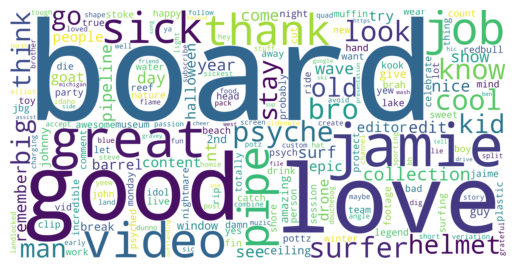

In [15]:
search.videos[vid1].create_commentsCloud()

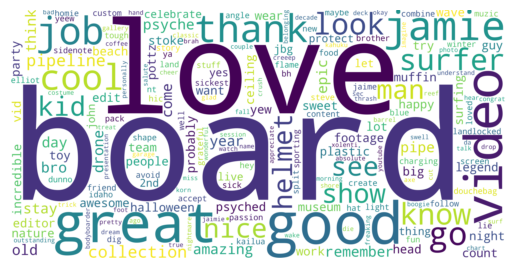

In [23]:
search.videos[vid1].create_commentsCloud(["Positive"])

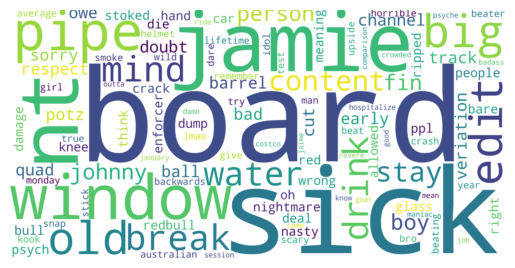

In [24]:
search.videos[vid1].create_commentsCloud(["Negative"])

In [16]:
# !pip install panel


---


# PANELLING

In [17]:
import panel as pn
pn.extension()

youtube_logo = pn.pane.JPG(
    'https://1000logos.net/wp-content/uploads/2021/04/YouTube-logo.png',
    link_url='https://www.youtube.com',
    width=400
)


search_keyword_input = pn.widgets.TextInput(name='Search Youtube', placeholder='Enter a text here...')

search_by = pn.widgets.AutocompleteInput(
    name='Search By', options=["date", "rating", "relevance", "viewCount"],
    placeholder='Default: By Relevance', restrict = True)



In [18]:
# getting video thumbnails

vid_thumb = []

for vid in search.videos.values():
    thumb = pn.pane.JPG(
    vid.metaData["thumbnail"],
    link_url=f'https://www.youtube.com/watch?v={vid.metaData["videoId"]}',
    width=400
    )
    
    vid_thumb.append(thumb)
    


In [19]:
# creating the comparison table to be put on the website


# Create an empty DataFrame with the desired column names
columns = ["Date Of Publish Of Video", "Number Of Likes On Video", "Number Of Views On Video", "Name Of Channel", "Number Of Subscribers Of Channel", "Number of Views On Channel", "Total Number Of Videos Uploaded"]
metaData_df = pd.DataFrame(columns=columns)

# Create an empty list to store rows
rows = []

# Iterate through the videos and add data as rows
for video in search.videos.values():
    row = {
        "Date Of Publish Of Video": video.metaData["videoPublishTime"],
        "Number Of Likes On Video": video.metaData["likeCount"],
        "Total Number Of Comments On Video" : video.metaData["commentCount"],
        "Number Of Views On Video": video.metaData["viewCount"],
        "Name Of Channel": video.channelData["channelName"],
        "Number Of Subscribers Of Channel": video.channelData["subscriberCount"],
        "Number of Views On Channel": video.channelData["viewCount"],
        "Total Number Of Videos Uploaded": video.channelData["videoCount"]
    }
    rows.append(row)

# Concatenate the list of rows to create the DataFrame
metaData_df = pd.concat([metaData_df, pd.DataFrame(rows)])

# Now, metaData_df contains the video metadata as rows, and you've avoided the deprecated .append method.


# Transpose the DataFrame
metaData_df = metaData_df.T

titles = []
for video in search.videos.values():
    titles.append(video.metaData["videoTitle"])

metaData_df.columns = titles
metaData_df.columns.name = "Name Of Video->"
metaData_df
# Now, metaData_df contains the video metadata with attributes as columns and videos as rows.


/var/folders/5w/t4s77l3x4js5bxj153dkk2zm0000gn/T/ipykernel_53732/1515488222.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metaData_df = pd.concat([metaData_df, pd.DataFrame(rows)])


Name Of Video->,EVERY SURFERS WORST NIGHTMARE AT PIPELINE!,RIDE OF THE YEAR AND SURFER OF THE YEAR AT BIG WAVE AWARDS!,Surfing with his son on his back!❤️😲,Tropical Cyclone Surf 2023: Earliest Ever For Australia,The BEST of Surfing in 2022
Date Of Publish Of Video,2023-10-30 19:00:17+00:00,2023-10-31 00:51:49+00:00,2023-09-21 03:00:06+00:00,2023-10-30 01:32:14+00:00,2023-02-01 19:14:10+00:00
Number Of Likes On Video,2753,1079,3447115,195,10049
Number Of Views On Video,57147,13100,79484943,31981,391123
Name Of Channel,Jamie O'Brien,Nathan Florence,Wiry,Surfline,Red Bull Surfing
Number Of Subscribers Of Channel,915000,397000,414000,229000,274000
Number of Views On Channel,241753096,160545186,256655718,101488530,127230723
Total Number Of Videos Uploaded,843,433,135,2780,797
Total Number Of Comments On Video,161,199,12613,26,43


In [20]:
# creating the grid
gspec = pn.GridSpec(sizing_mode='stretch_both', max_height=200)





# Place your components within the grid

gspec[0:2, 0:2] = pn.panel(youtube_logo)
gspec[0, 2:5] = pn.panel(search_keyword_input)
gspec[0, 5] = pn.panel(search_by)






# Create the Panel app with the responsive GridSpec
app = pn.panel(gspec)


In [21]:
# Instantiate the template with widgets displayed in the sidebar
template = pn.template.BootstrapTemplate(
    title='BootstrapTemplate',
    main = app,
    sidebar = [about_us_button],
    theme = "dark"
)
template.main.append(pn.Row(*vid_thumb))  # *image_row: The * symbol before image_row is known as the "splat" operator. It is used to unpack the elements of the image_row list. When we use *image_row, it effectively passes each image pane in the list as a separate argument to the pn.Row function. This is necessary because pn.Row expects its child components to be passed as separate arguments, not as a list.
template.main.append(pn.pane.HTML(metaData_df))

template.show();

NameError: name 'about_us_button' is not defined

# About Us Page

In [ ]:
def about_us_page(event):
    about_us_text = """
    Welcome to our About Us page! We are a team of dedicated developers working on creating amazing data visualizations with Panel.
    """
    return pn.panel(about_us_text)


In [ ]:
about_us_button = pn.widgets.Button(name="About Us")

# def open_about_us(event):
#     return about_us_page()

about_us_button.on_click(about_us_page)
